## Project - Predicting Insurance Costs (Linear Regression)

The scope of this project is to build the best possible predictive model for the medical insurance cost, given some demographic or personal characteristics of patients. The cost is a continuous, positive number, which makes it a good candidate for a linear regression.

We are using the [Medical Cost Data Set](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download) from Kaggle that contains information on individual medical insurance bills, each of them being associated with some demographic and personal characteristics of the person who received it.

![Image](https://images.unsplash.com/photo-1637763723578-79a4ca9225f7?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2071&q=80)
__Photo by Vlad Deep on Unsplash__

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
insurance=pd.read_csv("C:/Users/Denisa/Desktop/Project Apps/project 19/insurance.csv")

### Table of Contents
`age`- age of primary beneficiary

`sex`-insurance contractor gender, female, male

`bmi`- Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

`children`-Number of children covered by health insurance / Number of dependents

`smoker`-Smoking

`region`-the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

`charges`-Individual medical costs billed by health insurance

### Exploring The Dataset

The first step in building our linear model is to familiarize with the dataset to find potential candidates that are highly correlated with the outcome.

In [3]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


The `charges` column is our outcome. The other columns are potential predictors to use in the model.

array([[<AxesSubplot:title={'center':'charges'}>]], dtype=object)

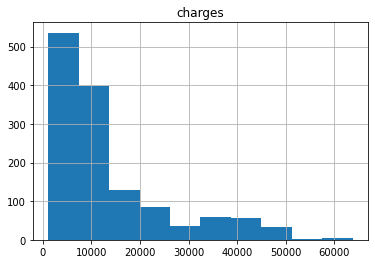

In [5]:
insurance.hist("charges")

The `charges` column is highly skewed to the right. This makes it unlikely that the residuals in the model will have zero as mean when checked against the predicted values. Next we will transform the outcome so that extreme values are less pronounced using log-transformation.

array([[<AxesSubplot:title={'center':'log_charges'}>]], dtype=object)

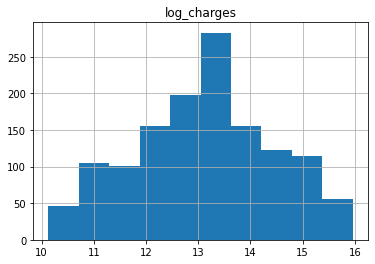

In [6]:
insurance["log_charges"] = np.log2(insurance["charges"])
insurance.hist("log_charges")

Now the outcome has a more similar Gaussian distribution  that makes it more likely that the residuals will have constant variance, being unbiased.

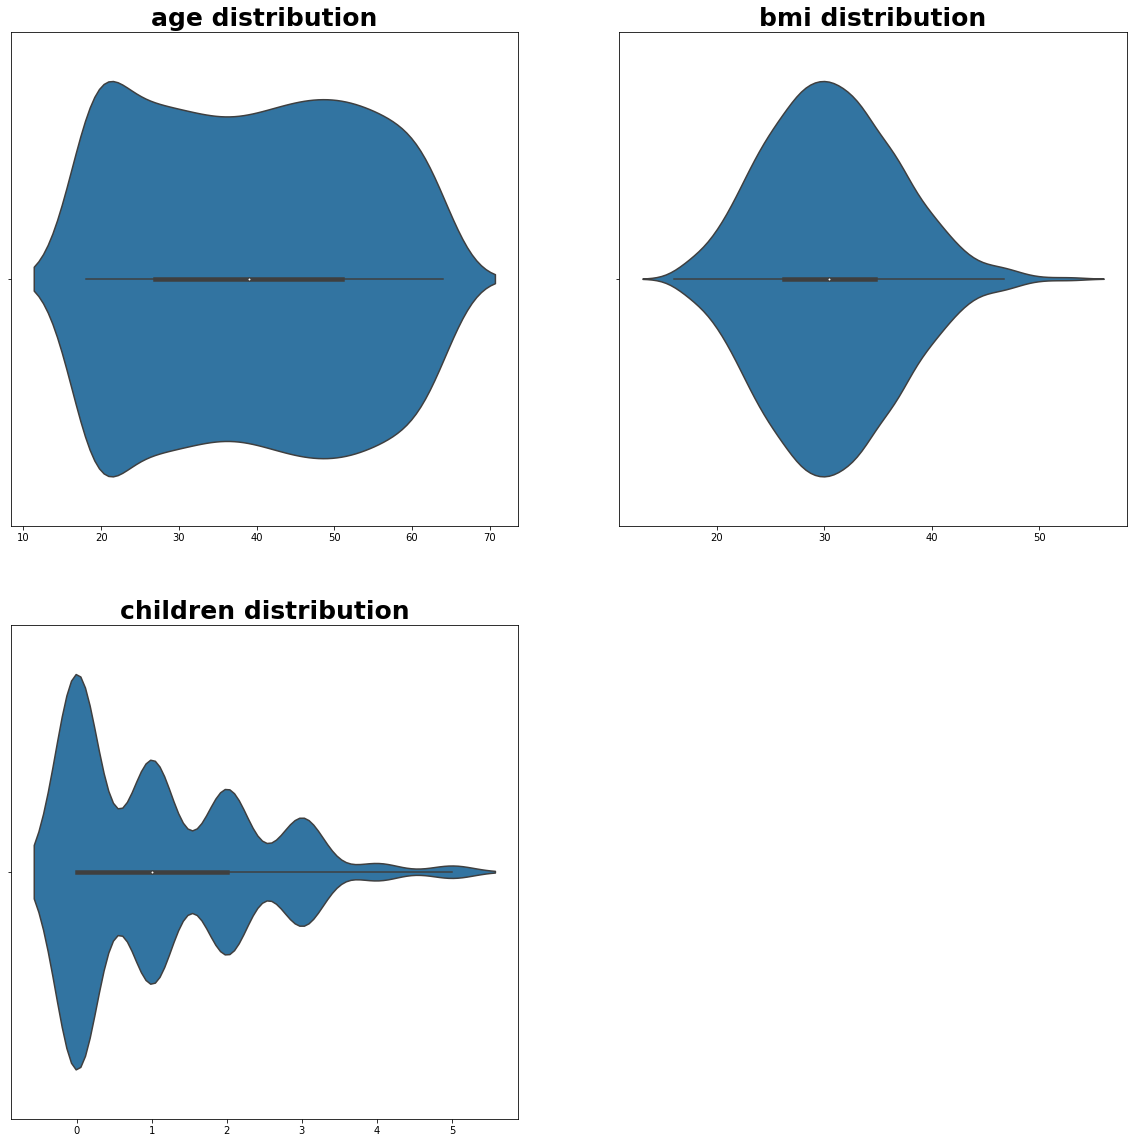

In [7]:
plt.figure(figsize=(20,20))

num_dist=['age','bmi','children']

for i, num in enumerate(num_dist):
    plt.subplot(2,2,i+1)
    sns.violinplot(data=insurance, x=num)
    plt.title(f'{num} distribution', weight='bold', fontsize=25)
    plt.xlabel('')
plt.show()    

Checking the relationships between the potential predictor variables that are categorical with the outcome via plots

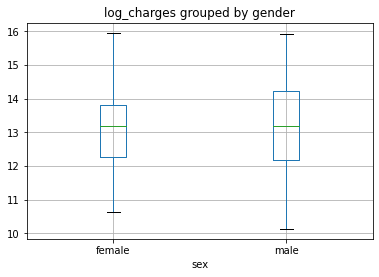

In [8]:
axes=insurance.boxplot(column = ["log_charges"], by = "sex")
title_boxplot = 'log_charges grouped by gender'
plt.title( title_boxplot )
plt.suptitle('') 
plt.show()

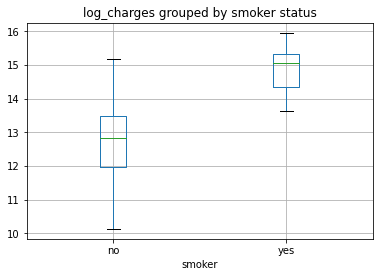

In [9]:
insurance.boxplot(column = ["log_charges"], by = "smoker")
title_boxplot = 'log_charges grouped by smoker status'
plt.title( title_boxplot )
plt.suptitle('') 
plt.show()

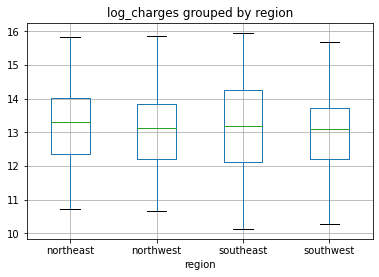

In [10]:
insurance.boxplot(column = ["log_charges"], by = "region")
title_boxplot = 'log_charges grouped by region'
plt.title( title_boxplot )
plt.suptitle('') 
plt.show()

Males seem to have a wider distribution of charges compared to women. Smokers have much higher costs than non-smokers. There doesn't seem tobe many appreciable differences between regions. We will convert the gender and smoker categorical columns to numeric.

In [11]:
insurance_modif=insurance.copy()
insurance_modif['sex']=insurance_modif['sex'].apply(lambda x: 1 if x=='male' else 0)

insurance_modif['smoker']=insurance_modif['smoker'].apply(lambda x: 1 if x=='yes' else 0)

Checking the correlations between each of the predictor variables and the outcome

In [12]:
insurance_modif.corr()

,age,sex,bmi,children,smoker,charges,log_charges
age,1.000000,-0.020856,0.109272,0.042469,-0.025019,0.299008,0.527834
sex,-0.020856,1.000000,0.046371,0.017163,0.076185,0.057292,0.005632
bmi,0.109272,0.046371,1.000000,0.012759,0.003750,0.198341,0.132669
children,0.042469,0.017163,0.012759,1.000000,0.007673,0.067998,0.161336
smoker,-0.025019,0.076185,0.003750,0.007673,1.000000,0.787251,0.665506
charges,0.299008,0.057292,0.198341,0.067998,0.787251,1.000000,0.892964
log_charges,0.527834,0.005632,0.132669,0.161336,0.665506,0.892964,1.000000


Some striking relationships that we observe among the correlations:
* age has 30% correlation with charges, 
* bmi has 19.8% correlation, 
* smoker  has 78.7% correlation
* number of children has 6.7% correlation.
* sex has 5.7% correlation

### Dividing The Data

Based on the statistical measure shown above thourgh correlation we will choose age, bmi and smoker are predictors for our model. Next we will divide the dataset into the:

* training set that will be used to estimate the regression coefficients
* test set that will be used to assess the predictive ability of the model

In [13]:
X = insurance_modif[["age", "bmi", "smoker"]]
y = insurance_modif["log_charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, 
                                                    random_state = 1)

### Build The Model

In [14]:
insurance_model = LinearRegression()
insurance_model.fit(X_train, y_train)

LinearRegression()

In [15]:
# Get predicted values by model
y_pred = insurance_model.predict(X_train)

Checking the zero mean assumption on the residuals to assess the average amount ofsquared error in the data

In [16]:
# MSE on the log scale for the insurance charges
mean_squared_error(y_train, y_pred)

0.4546665339270644

In [17]:
# MSE on the original scale for the insurance charges
np.exp(mean_squared_error(y_train, y_pred))

1.575647870310887

Examining the error metric coefficient of determination to see how well the model accounts for the variance in the outcome and how well the model approximates the data.

In [18]:
r2_score(y_train, y_pred)

0.7421118855283421

The coefficient of determinatio nindicates that the model can explain 74% of the variation in the log-insurance charges.

### Residual Diagnostics

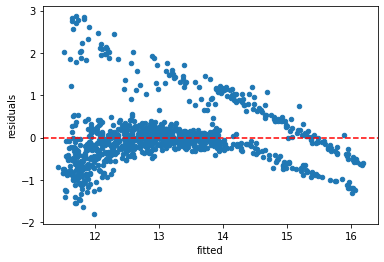

In [19]:
df = pd.DataFrame()
df["residuals"] = y_train - y_pred
df["fitted"] = y_pred

df.plot.scatter(x = "fitted", y = "residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

The residuals suggest some violations to the assumptions of linear regression. As fitted values get larger, the residuals trend downward. We expect an even band, centered around zero. This does not necessarily make the model predictions unusable, but it puts into question the linear regression assumptions.

### Interpreting The Model

In [20]:
insurance_model.coef_

array([0.04892865, 0.01523672, 2.23063344])

In [21]:
np.exp(2.23063344)

9.305758852815107

* A year increase for a patient is associated with a 0.04 increase in the log charges, holding smoking status and bmi constant. 
* A unit increase in the subject BMI is associated with a 0.01 increase in the log charges, holding smoking status and age constant. 
* A smoker is associated with a 2.23 increase in the log charges, holding age and bmi constant. About a 930% increase in the charges on the regular scale.

### Final Model Evaluation

Observing the model's predictive ability on the test data.

In [22]:
test_pred = insurance_model.predict(X_test)

mean_squared_error(y_test, test_pred)

0.4355350875308211

In [23]:
# Putting the outcome (in log-terms) back into the original scale
np.exp(mean_squared_error(y_test, test_pred))

1.545789970635098

### Drawing Conclusions

The test MSE was about 0.435, while the training MSE was about 0.454. In this case, the two errors match up pretty well, so we can conclude that the model is not overfit. The residuals suggest that the model is predicting much lower costs for subjects who were actually charged much higher. We can conclude that the model doesn't perform too well when it comes to higher costs.

We might improve the model by including more complex terms in the regression, such as interactions or quadratic terms.